# EDA for Earthquakes

In [1]:
# Load the libraries we'll use
######################################

# Basic numerics
import numpy as np
import scipy as sp
import scipy.stats as st

# Data handling
import pandas as pd

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# Statistical tools
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm

Before doing anything else, we make sure there's a directory to receive the figures we'll plot.

In [2]:
# https://www.tutorialspoint.com/How-can-I-create-a-directory-if-it-does-not-exist-using-Python
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

## Read the data

Pandas has convenient, built-in functions to read CSV files.

In [4]:
# Read in the data as a Pandas dataframe
earthquake_df = pd.read_csv('./earthquakes_US_14Jul-13Aug_2018.csv')
earthquake_df.head() # shows the first few rows of the dataframe

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2018-08-13T20:32:00.830Z,33.860333,-117.501167,1.50,1.56,ml,29.0,44.0,0.06337,0.2600,...,2018-08-13T20:35:51.429Z,"3km SE of Home Gardens, CA",quarry blast,0.38,0.71,0.213,37.0,automatic,ci,ci
1,2018-08-13T20:15:08.350Z,33.523667,-116.747333,3.69,0.40,ml,14.0,90.0,0.04246,0.0800,...,2018-08-13T20:18:36.325Z,"8km WSW of Anza, CA",earthquake,0.18,0.42,0.137,9.0,automatic,ci,ci
2,2018-08-13T20:11:13.973Z,40.601000,-115.955500,0.00,2.20,ml,12.0,108.3,0.43800,0.1944,...,2018-08-13T20:28:20.650Z,"17km SE of Carlin, Nevada",explosion,NaN,0.00,0.080,8.0,reviewed,nn,nn
3,2018-08-13T20:09:39.080Z,33.482333,-116.744333,7.91,0.34,ml,18.0,65.0,0.06527,0.1800,...,2018-08-13T20:13:23.288Z,"10km SW of Anza, CA",earthquake,0.35,0.86,0.093,8.0,automatic,ci,ci
4,2018-08-13T19:59:26.490Z,33.491167,-116.795500,2.54,0.39,ml,11.0,109.0,0.08857,0.0800,...,2018-08-13T20:02:57.234Z,"8km NE of Aguanga, CA",earthquake,0.26,0.37,0.055,8.0,automatic,ci,ci


## Focus on the magnitudes

In [5]:
# Extract a univariate dataset consisting of the magnitudes 
magnitudes = earthquake_df.mag.values

The block of code below draws a combined rug plot (lossless), histogram (lossy) and kernel density estimate (KDE, lossy). 

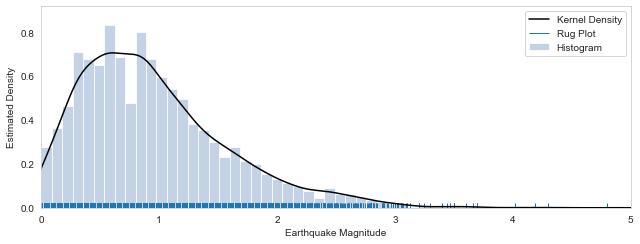

In [6]:
# Set the dimensions of the plot
widthInInches = 9
heightInInches = 3.5
plt.figure( figsize=(widthInInches, heightInInches) )

# Draw histograms and KDEs using commands suited to  
# the installed version of Seaborn.
seabornVersionStr = sns.__version__
versionStrParts = seabornVersionStr.split('.')
if( int(versionStrParts[1]) < 11 ):
    # Use the older, now-deprectaed form
    kdeAxes = sns.distplot( magnitudes,
                 kde_kws={"label": "Kernel Density", "color" : "black"},
                 hist_kws={"label": "Histogram", "color" : 'lightsteelblue'}
            )
else:
    # Use the more recent form
    kdeAxes = sns.kdeplot( magnitudes, color="black", label="Kernel Density")
    sns.histplot( magnitudes, stat="density", color = "lightsteelblue", label="Histogram"  )

# Finally, add a rug plot
sns.rugplot( magnitudes, label="Rug Plot" )

# Add labels
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Estimated Density')

# Add tick marks abd set the limits of the axes
plt.xticks((0,1,2,3,4,5))
plt.xlim([0,5])
plt.legend()
plt.tight_layout()

# Save a PDF version, then display the result here too
plt.savefig('Figures/earth_distplot.pdf')
plt.show()

In [7]:
seabornVersionStr

'0.11.0'

## Summary statistics

Here we compute the mean and variance of the magniudes, using tools built into numpy

In [8]:
np.mean(magnitudes)

0.9555100148367953

#### Biased and unbiased estimates of the variance

By default, numpy computes the biased estimate of the variance ...

In [9]:
np.var(magnitudes)

0.400257047006528

but it's easy to compute the unbiaed one too. For a sample as large as the one we have here, the two estimates don't differ much.

In [10]:
np.var(magnitudes,ddof=1)

0.40033129242426246

#### Estimates of the standard deviation, third moment and excess kurtosis

In [11]:
ss = np.sqrt(np.var(magnitudes))

In [12]:
sp.stats.moment(magnitudes,3)/(ss**3)

1.0710553097009332

In [13]:
(sp.stats.moment(magnitudes,4)/(ss**4)) - 3

1.4368380067616835

## Measures of central tendency

Estimate the mean, median and mode and add them to the density plot.

In [14]:
# The mean and median are straightforward:
meanMagnitude = np.mean(magnitudes)
medianMagnitude = np.median(magnitudes)

Here we take a practical, if somewhat fiddly, approach to estimating the mode.

In [15]:
# Examine the density plot made above and extract the list of (x,y) 
# pairs used to draw the KDE curve
kdeX, kdeY = kdeAxes.get_lines()[0].get_data()

# Also get the limits of the vertical axis: we'll want these to
# draw markers for the mean, median and mode.
kdeYLimits = kdeAxes.get_ylim()
kdeYMax = kdeYLimits[1]

# Find the position in the list of y values where the maximum y-value occurs
posOfMax = 0 
maxSoFar = kdeY[0] 
for j in range(len(kdeY)):
    if( kdeY[j] > maxSoFar ):
        posOfMax = j
        maxSoFar = kdeY[j]
# 
# Use the corresponding x value as an estimate of the median.
magnitudeMode = kdeX[posOfMax]

#### Plot the KDE curve, then add vertical lines for the mean, median and mode

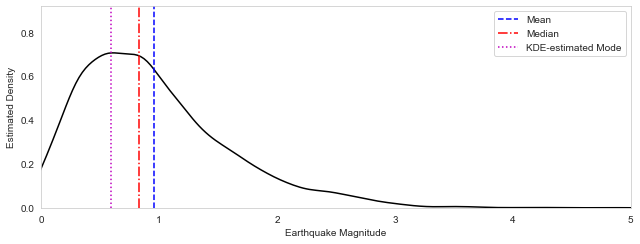

In [16]:
# Set the dimensions of the plot
plt.figure( figsize=(widthInInches, heightInInches) )

# Plot the kernel density estimate curve
plt.plot(kdeX, kdeY, '-k')

# Get ready to plot vertical lines
xx = np.ones(2)
yy = np.array([0, kdeYMax])

# Add variouosly dashed vertical lines for the three
# measures fo central tendency
plt.plot( meanMagnitude*xx, yy,'--b',label='Mean')
plt.plot( medianMagnitude*xx, yy,'-.r',label='Median')
plt.plot( magnitudeMode*xx, yy,':m',label='KDE-estimated Mode')

# Add labels and set the positions of the tick marks
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Estimated Density')
plt.ylim(kdeYLimits)
plt.xlim([0,5])
plt.xticks((0,1,2,3,4,5))

# Add a legend
plt.legend()
plt.tight_layout()

# Save a copy as a PDF, then show the figure
plt.savefig('Figures/earth_central.pdf')
plt.show()

## Empirical Cumulative Density Function (ECDF)

The `statsmodels` package includes routines to compute this easily. The result has two parts, a list of $x$ values and a corresponding list of $y$ values.

In [17]:
# Get the curve. 
ecdf=ECDF(magnitudes)

Next we plot the curve. It's piecewise constant, with a vertical jump of $1/n$ at each $x$ value that occurs in the data.

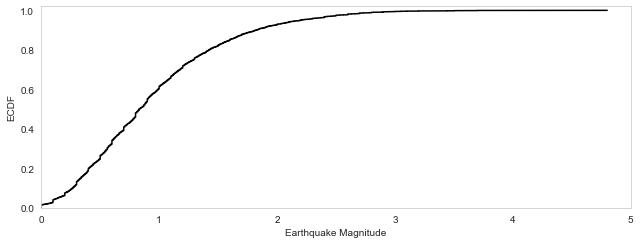

In [18]:
# Set the dimensions of the plot
plt.figure( figsize=(widthInInches, heightInInches) )

# Draw the curve
plt.step(ecdf.x, ecdf.y, c='k')

# Add captions, tick marks and the like
plt.xlabel('Earthquake Magnitude')
plt.ylabel('ECDF')
plt.ylim([0,1.02])
plt.xlim([0,5])
plt.xticks((0,1,2,3,4,5))
plt.tight_layout()

# Blap the image out, both to a file and to the screen
plt.savefig('Figures/earth_ecdf.pdf')
plt.show()

#### Empirical quantiles

Once we have the ECDF, we can use it to find estimates of the quantiles. Here we compute the positions of the 25th, 50th, 75th, 90th and 99th.

In [19]:
p25 = np.percentile(magnitudes,25)
p50 = np.percentile(magnitudes,50)
p75 = np.percentile(magnitudes,75)
p95 = np.percentile(magnitudes,95)
p99 = np.percentile(magnitudes,99)

Now draw them on the same axes as the ECDF.

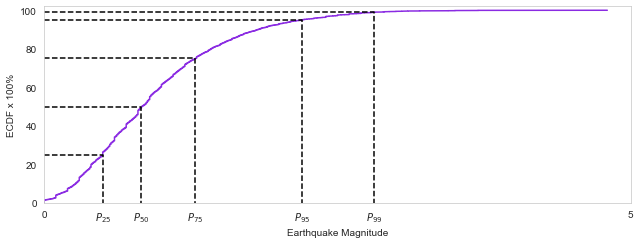

In [20]:
# Set the dimensions of the plot
plt.figure( figsize=(widthInInches, heightInInches) )

# Draw the ECDF as a solid curve
plt.step(ecdf.x, 100*ecdf.y, color='blueviolet' )

# Add dashed lines for the quantiles computed above.
plt.plot([0,p25,p25],[25, 25, 0],'--k')
plt.plot([0,p50,p50],[50, 50, 0],'--k')
plt.plot([0,p75,p75],[75, 75, 0],'--k')
plt.plot([0,p95,p95],[95, 95, 0],'--k')
plt.plot([0,p99,p99],[99, 99, 0],'--k')

# Add axis lables, tick marks and the like
plt.xlabel('Earthquake Magnitude')
plt.ylabel('ECDF x 100%')
plt.ylim([0,102])
plt.xlim([0,5])
plt.xticks((0,p25,p50,p75,p95,p99,5),('0','$P_{25}$','$P_{50}$','$P_{75}$','$P_{95}$','$P_{99}$','5'))
plt.tight_layout()

# Blap the image out, both to a file and to the screen
plt.savefig('Figures/earth_q_ecdf.pdf')
plt.show()

#### The survival function

This function gets its name from a different application, where the hosizontal axis is measured in time units &mdash; years, say &mdash; and the vertical axis shows the fraction of an initial popultion who survive to the given age.

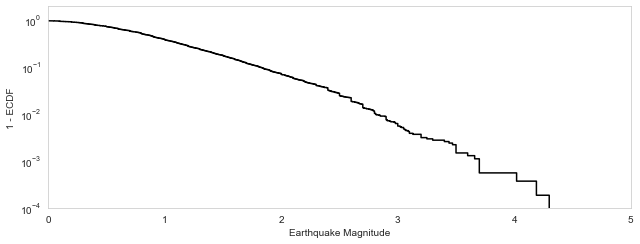

In [45]:
# Set the dimensions of the plot
plt.figure( figsize=(widthInInches, heightInInches) )

# Add the survival function, which is just 1 - ECDF
plt.step(ecdf.x,1-ecdf.y,c='k')

# Add axis lables, tick marks and the like
plt.xlabel('Earthquake Magnitude')
plt.ylabel('1 - ECDF')
#plt.xscale('log')
plt.yscale('log') # Put y on a log scale
plt.xlim([0,5])
plt.xticks((0,1,2,3,4,5))
plt.ylim((1e-4,2))
plt.tight_layout()

# Blap the image out, both to a file and to the screen
plt.savefig('Figures/earth_ll_ecdf.pdf')
plt.show()

#### The interquartile range (IQR)

A standard measure of the spread, or dispersal of the data is the interqartile range: the dofference between the 1st and 3rd quartiles. Here we calculate it in two ways: first directly, using the 25th and 75th precentiles computed above, and then again using built-in routine from `scipy.stats`.

In [22]:
# Directly, form percentils
p75-p25

0.79

In [23]:
# Using scipy.stats
st.iqr(magnitudes)

0.79

## Density estimation

In this section we explore in more detail two approaches to estimating the undelying density from which a sample of continuously-distributed data has been drawn.

### Histogram as a density estimate

The block below computes two estimates of the density of earthquake magnitude, that differ only in the number of bins used. The one with more, narrower bins is noisier as, necessarily, fewer counts fall into each bin.

#### Compute the two histograms

Do one with 10 bins and the other with 100. Also, print the total number of measurements.

In [50]:
yh10, xh10 = np.histogram(magnitudes,10, density=True)
yh100, xh100 = np.histogram(magnitudes,100, density=True)
len( magnitudes )

5392

#### Draw them on the same axes.

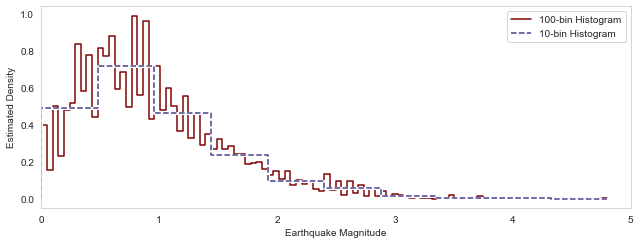

In [51]:
# Set the dimensions of the plot
plt.figure( figsize=(widthInInches, heightInInches) )

# Draw the density estimates
# The middle line draws a thick white line to clear space for the 10-bin histogram's curve
plt.step(xh100,np.concatenate((np.zeros(1),yh100)), color='maroon',label='100-bin Histogram')
plt.step(xh10,np.concatenate((np.zeros(1),yh10)),'w',linewidth=3)
plt.step(xh10,np.concatenate((np.zeros(1),yh10)), color='darkslateblue', linestyle='dashed',label='10-bin Histogram')

# Add axis lables, tick marks and the like
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Estimated Density')
plt.xlim([0,5])
plt.xticks((0,1,2,3,4,5))
plt.legend()
plt.tight_layout()

# Blap the image out, both to a file and to the screen
plt.savefig('Figures/earth_hists.pdf')
plt.show()

## Kernel density estimates

First we compute density estimates using three standard kernels: the uniform, triangular and Gaussian kernels.

In [47]:
# Uniform (box-shaped) kernel
mykde = sm.nonparametric.KDEUnivariate(magnitudes)
mykde.fit(kernel="uni", fft=False)
xuni = mykde.support
yuni = mykde.density

# Triangular kernel
mykde2 = sm.nonparametric.KDEUnivariate(magnitudes)
mykde2.fit(kernel="tri", fft=False)
xtri = mykde2.support
ytri = mykde2.density

# Gaussian kernel
mykde3 = sm.nonparametric.KDEUnivariate(magnitudes)
mykde3.fit(kernel="gau")
xgau = mykde3.support
ygau = mykde3.density

Next we plot them in pairs, for comparison. First up: Gaussian and uniform.

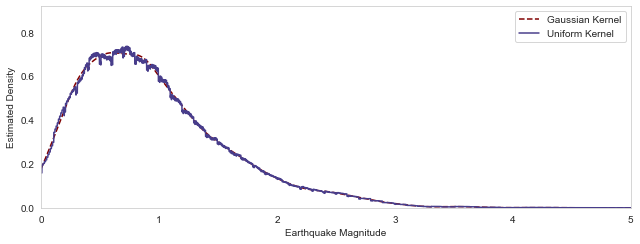

In [27]:
# Set the dimensions of the plot
plt.figure( figsize=(widthInInches, heightInInches) )

# Plot the two estimates
plt.plot(xgau,ygau,label='Gaussian Kernel',color='maroon',linestyle='--')
plt.plot(xuni,yuni,label='Uniform Kernel',color='darkslateblue',linestyle='-')

# Add axis lables, tick marks and the like
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Estimated Density')
plt.ylim(kdeYLimits)
plt.xlim([0,5])
plt.xticks((0,1,2,3,4,5))
plt.legend()
plt.tight_layout()

# Blap the plot out, both to a file and to the screen
plt.savefig('Figures/earth_uni.pdf')
plt.show()

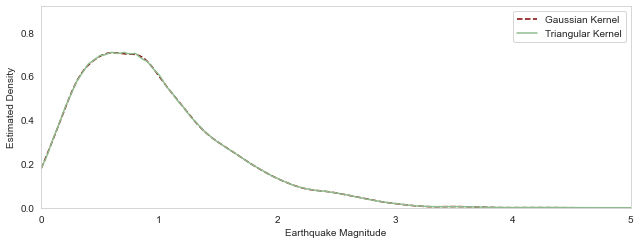

In [28]:
# Set the dimensions of the plot
plt.figure( figsize=(widthInInches, heightInInches) )

# Plot the two estimates
plt.plot(xgau,ygau,label='Gaussian Kernel',color='maroon',linestyle='--')
plt.plot(xtri,ytri,label='Triangular Kernel',color='darkseagreen',linestyle='-')

# Add axis lables, tick marks and the like
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Estimated Density')
plt.ylim(kdeYLimits)
plt.xlim([0,5])
plt.xticks((0,1,2,3,4,5))
plt.legend()
plt.tight_layout()

# Blap the plot out, both to a file and to the screen
plt.savefig('Figures/earth_tri.pdf')
plt.show()